Linear regression model

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import os
from pathlib import Path

In [2]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    PROJECT_PATH = str(Path(os.getcwd(), 'datasets', ticker+'.csv'))
    data = pd.read_csv(PROJECT_PATH, index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

In [3]:
data = read_data('NQ')

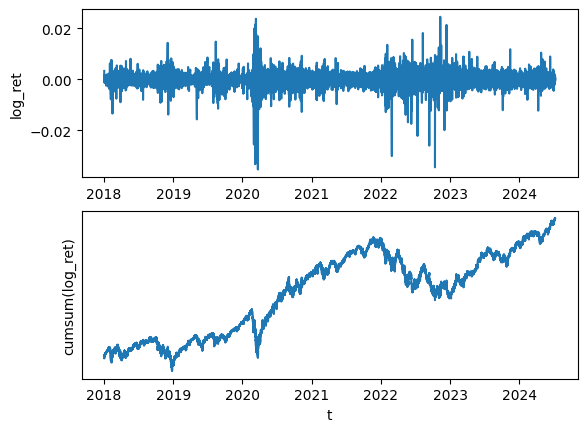

In [11]:
# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

Functions for calculating standard statistics on the daily equity curve:

In [4]:
days_in_year = 365.25

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Features generation:

In [5]:
def make_features(data, pref = ''):
    features = pd.DataFrame(index = data.index)

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret']/features['vol']

    periods = (np.logspace(2.0, 4.0, num = 10)).astype(int)
    print(periods)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'hann').mean()).shift(1)
    features = features.dropna()
    return features

Creating and training a linear regression model (Ridge)

[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 0.62
Annual Return = 0.09
Annual Std = 0.15


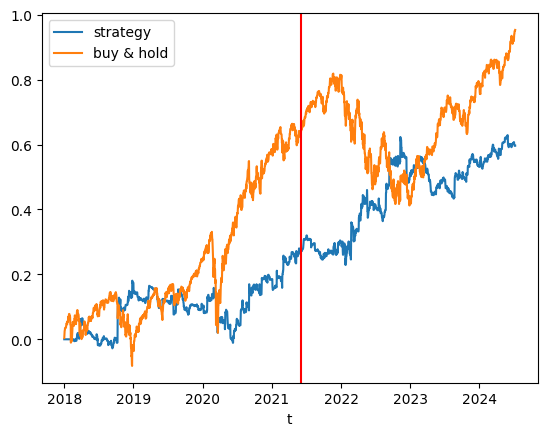

In [6]:
in_sample_start = '2018-01-01'
in_sample_end = '2021-06-01'

features =  make_features(data)

y = features['normalized_log_ret']
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']]

X_train = X.loc[in_sample_start:in_sample_end]
y_train = y.loc[in_sample_start:in_sample_end]
X_test = X.loc[in_sample_end:]
y_test = y.loc[in_sample_end:]

clf = Ridge(alpha = 500, fit_intercept = False, solver = 'saga')

clf.fit(X_train, y_train)

features['position'] = clf.predict(X)/ clf.predict(X_train).std()

features['position'] = features['position'].ewm(alpha = 0.1).mean()

# We trade whole lots
features['position'] = features['position'].fillna(0).astype(int)

# Maximum position limit
pos_limit = 4
features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

slippage = 0.00001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Calculate statistics on test data:

Sharpe ratio = 0.68
Annual Return = 0.10
Annual Std = 0.15


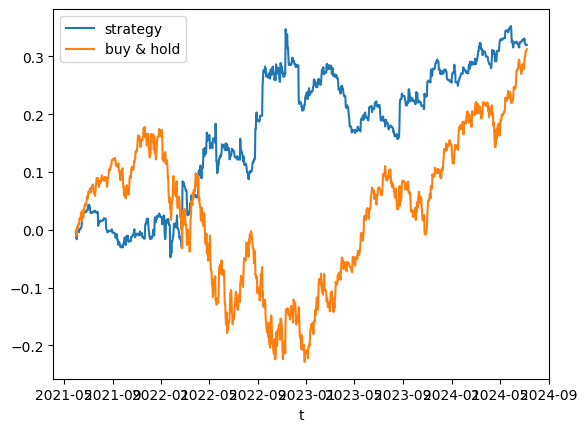

In [7]:
stats = statistics_calc(eq[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], bh[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], plot = True)

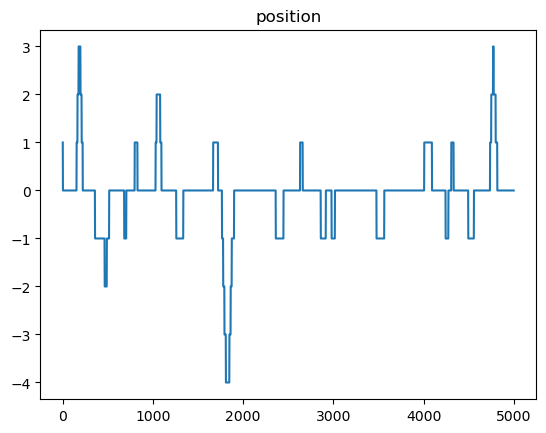

In [ ]:
plt.plot(np.arange(5000), features['position'][-5000:])
_ = plt.title('position')

Visualization of different levels of regularization

In [ ]:
n_alphas = 100
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
r2_train = []
r2_test = []
for a in alphas:
    ridge = Ridge(alpha = a, fit_intercept = False, solver = 'saga')
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    r2_train.append(r2_score(y_train, ridge.predict(X_train)))
    r2_test.append(r2_score(y_test, ridge.predict(X_test)))

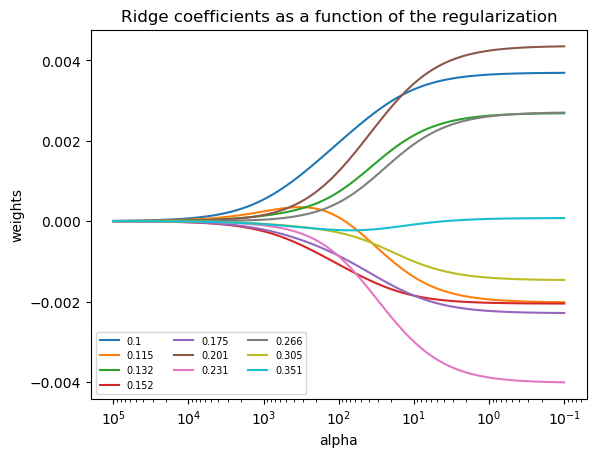

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # Reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.legend(np.round(alphas, decimals = 3), loc = 'lower left', prop = {'size': 7}, ncol = 3)
plt.title("Ridge coefficients as a function of the regularization")
_ = plt.axis("tight")

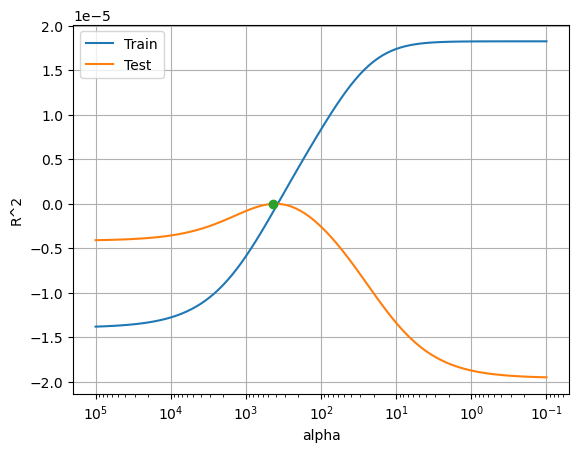

In [ ]:
ax = plt.gca()

ax.plot(alphas, r2_train, label = 'Train')
ax.plot(alphas, r2_test, label = 'Test')

ax.plot(alphas[np.argmax(r2_test)], r2_test[np.argmax(r2_test)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # Reverse axis

ax.legend()
ax.grid()

plt.xlabel("alpha")
plt.ylabel("R^2")
plt.axis("tight")

plt.savefig(r'linear_r2.png', dpi = 1200)
plt.savefig(r'linear_r2_lowq.png')

Additional exercises and research topics:

1. Improve the strategy by feature engineering and using other regression models. Try other formulas for the target position calculation. Conduct detailed testing on various instruments using the walk-forward approach and stability analysis.

Добавим несколько новых признаков: несколько новых индикаторов, лаговые признаки.

In [6]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm import tqdm

def make_features(data, pref = ''):
    features = pd.DataFrame(index = data.index)

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret']/features['vol']

    periods = (np.logspace(2.0, 4.0, num = 10)).astype(int)
    print(periods)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'hann').mean()).shift(1)
        features['f_'+pref+'ema'+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].ewm(span=20, adjust=False).mean()).shift(1)
        
    # Добавление RSI
    delta = features['normalized_log_ret'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    features['f_rsi'] = 100 - (100 / (1 + rs))

    features['f_lag_1'] = features['normalized_log_ret'].shift(1)
    features['f_lag_2'] = features['normalized_log_ret'].shift(2)
    
    features = features.dropna()
    return features

Теперь проведем обучение и тестирование сразу нескольких моделей

[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 1.26
Annual Return = 1.02
Annual Std = 0.81


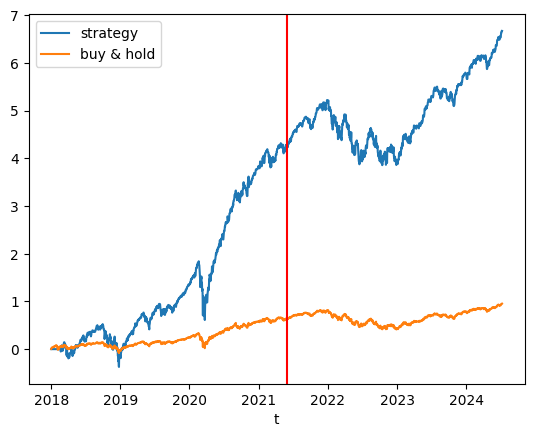

In [7]:
in_sample_start = '2018-01-01'
in_sample_end = '2021-06-01'

features =  make_features(data)

y = features['normalized_log_ret']
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']]

X_train = X.loc[in_sample_start:in_sample_end]
y_train = y.loc[in_sample_start:in_sample_end]
X_test = X.loc[in_sample_end:]
y_test = y.loc[in_sample_end:]

clf = Ridge(alpha = 500, fit_intercept = False, solver = 'saga')

clf.fit(X_train, y_train)

features['position'] = clf.predict(X)/ clf.predict(X_train).std()

features['position'] = features['position'].ewm(alpha = 0.1).mean()

# We trade whole lots
features['position'] = features['position'].fillna(0).astype(int)

# Maximum position limit
pos_limit = 4
features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

slippage = 0.00001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Sharpe ratio = 0.94
Annual Return = 0.77
Annual Std = 0.82


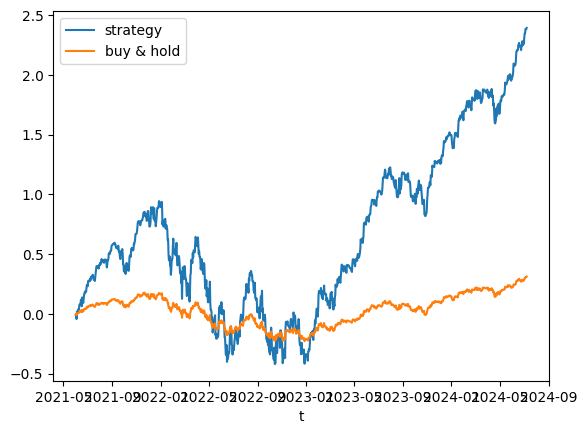

In [8]:
stats = statistics_calc(eq[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], bh[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], plot = True)

Добавив новые признаки, метрики выросли значительно. Будем далее пробовать с другими моделями

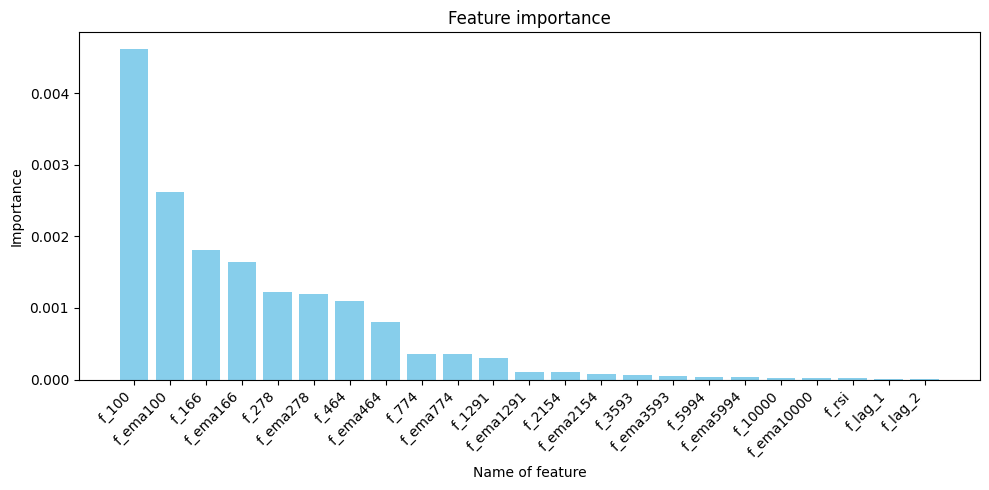

In [9]:
feature_names = X_train.columns
importance = np.abs(clf.coef_)

sort_idx = np.argsort(importance)[::-1]
feature_names_sort = np.array(feature_names)[sort_idx]
importance_sort = importance[sort_idx]

plt.figure(figsize=(10, 5))
plt.bar(feature_names, importance_sort, color='skyblue')
plt.xlabel("Name of feature")
plt.ylabel("Importance")
plt.title("Feature importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Посмотрели feature importance по абсолютному значению, соответствующих коэфициентов признаков в модели, но такой подход в случае L2-регуляризации не совсем корректно может отражать истиную важность признаков, так как регуляризация смещает значения.

Более корректный способ посмотреть на важность признаков это метод shap.

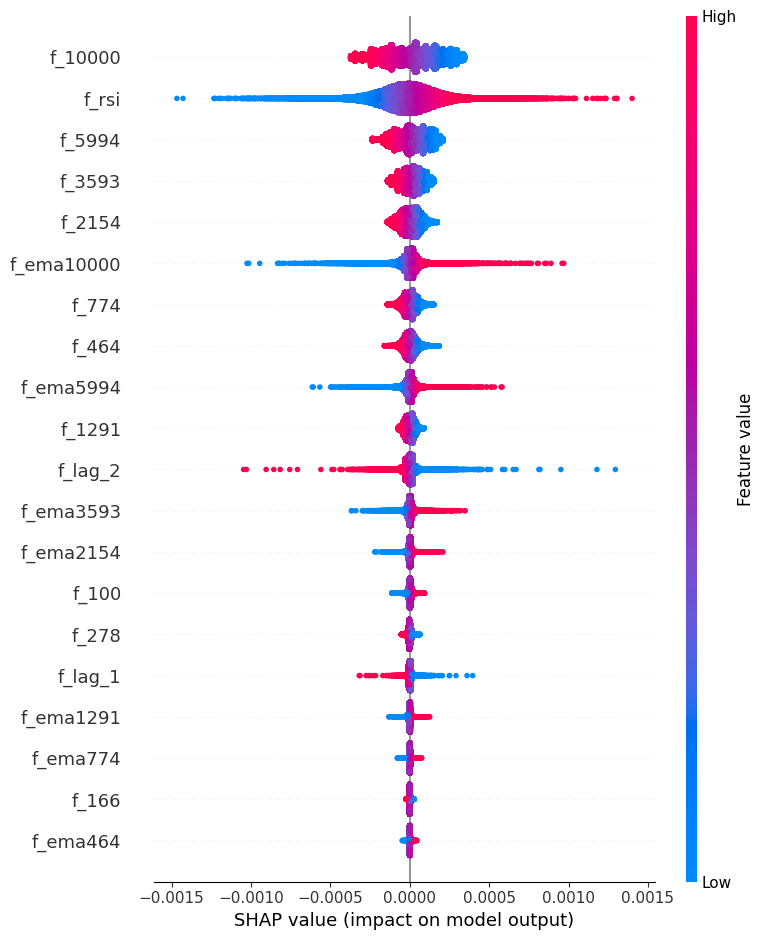

In [11]:
import shap
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

Видно, что картина сильно поменялась. Будем ориентироваться на эти значения

In [36]:
def plot_feature_correlation(data, feature_prefix='f_'):
    """
    Отображает матрицу корреляций признаков.

    :param data: DataFrame с данными.
    :param feature_prefix: Префикс для выбора колонок с признаками.
    """
    # Выбираем только признаки по префиксу
    feature_columns = [col for col in data.columns if col.startswith(feature_prefix)]
    feature_data = data[feature_columns]

    # Строим корреляционную матрицу
    corr_matrix = feature_data.corr()

    # Визуализируем
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.show()

[  100   166   278   464   774  1291  2154  3593  5994 10000]


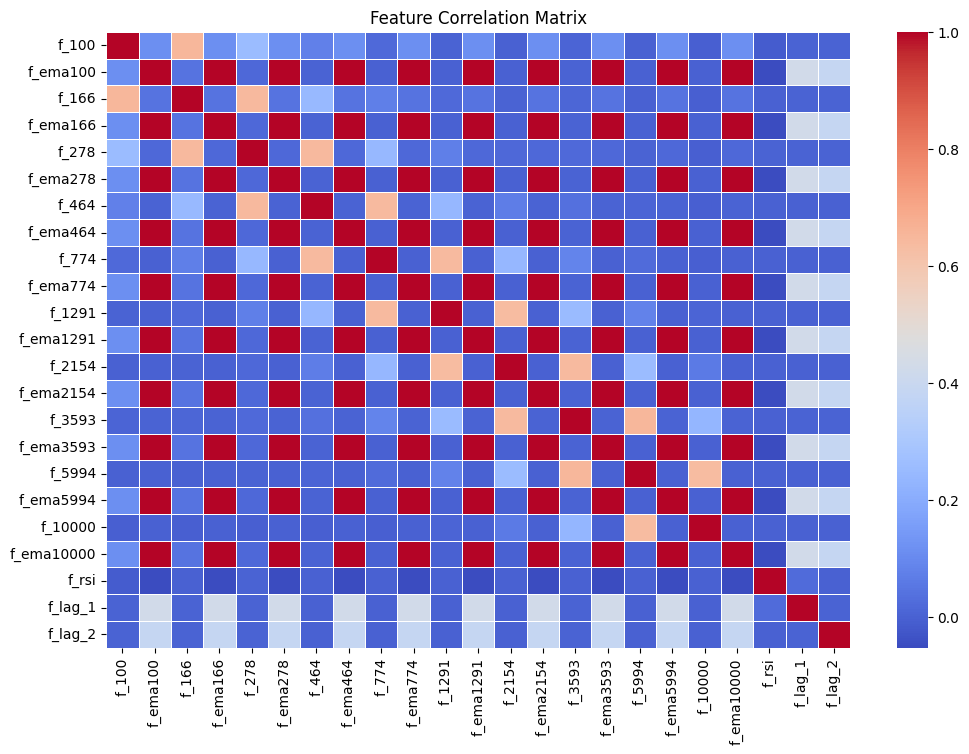

In [39]:
data = read_data('NQ')
data = make_features(data)
plot_feature_correlation(data)

Выше представлена матрица корреляций Пирсона признаков между собой. Видно, что признаки вида f_ema имеют много корреляций с коэфициентом близким к 1. По хорошему нужно произвести фильтрацию признаков по уровню корреляции между собой по какому нибудь порогу, например, 0.8. Так как линейные модели могут плохо работать с призанковым пространством, где имеются подобные случаи. Также для корректной работы моделей ML нужно убрать из признакого описания нестационарные признаки, но таких у нас вроде нет.

[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 0.55
Annual Return = 1.01
Annual Std = 1.82


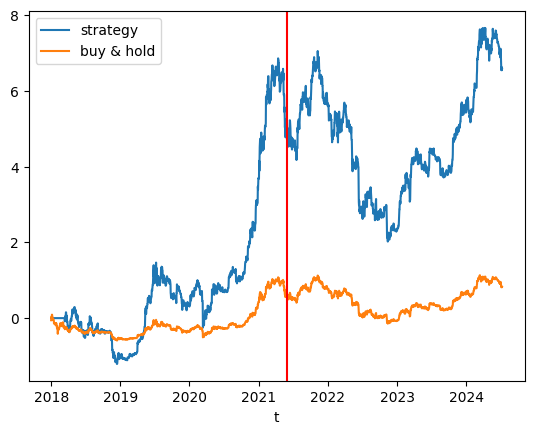

In [12]:
data = read_data('BTC')

in_sample_start = '2018-01-01'
in_sample_end = '2021-06-01'

features =  make_features(data)

y = features['normalized_log_ret']
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']]

X_train = X.loc[in_sample_start:in_sample_end]
y_train = y.loc[in_sample_start:in_sample_end]
X_test = X.loc[in_sample_end:]
y_test = y.loc[in_sample_end:]

clf = Ridge(alpha = 500, fit_intercept = False, solver = 'saga')

clf.fit(X_train, y_train)

features['position'] = clf.predict(X)/ clf.predict(X_train).std()

features['position'] = features['position'].ewm(alpha = 0.1).mean()

# We trade whole lots
features['position'] = features['position'].fillna(0).astype(int)

# Maximum position limit
pos_limit = 4
features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

slippage = 0.00001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Sharpe ratio = 0.27
Annual Return = 0.54
Annual Std = 1.99


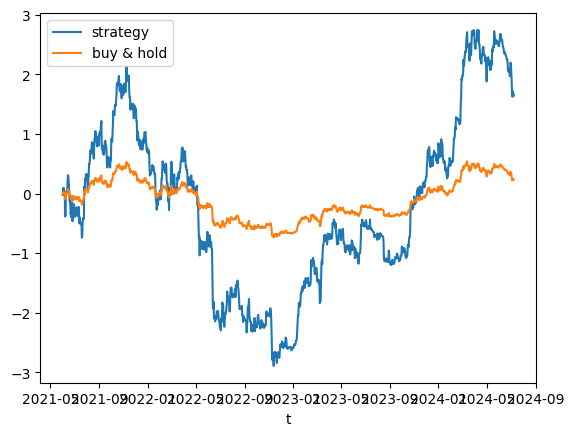

In [13]:
stats = statistics_calc(eq[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], bh[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], plot = True)

# walk-forward optimization

In [14]:
def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    max_drawdown = rets.cumsum().max() - rets.cumsum().min()
    
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
        print(f'Max drawdown = {max_drawdown}')
    return  pd.DataFrame([[sharpe, ret, vol, max_drawdown]], columns = ['Sharpe ratio', 'Annual return', 'Volatility', 'Max drawdown'], index = [name])

In [32]:
def walk_forward_optimization(data, model, train_size=0.7, test_size=0.2, target_col='normalized_log_ret', feature_prefix='f_', pos_limit=4):
    """
    Walk-forward оптимизация с гибкими размерами окон.

    :param data: DataFrame с данными.
    :param model: Модель, которая поддерживает fit и predict.
    :param train_size: Размер обучающего окна в процентах (например, 0.7 для 70%).
    :param test_size: Размер тестового окна в процентах (например, 0.2 для 20%).
    :param target_col: Название колонки с целевой переменной.
    :param feature_prefix: Префикс для колонок с признаками.
    :return: DataFrame с результатами для каждого тестового окна.
    """
    results = []
    total_samples = len(data)
    train_samples = int(total_samples * train_size)
    test_samples = int(train_samples * test_size)  # Теперь test_size - процент от train_size
    step = test_samples  # Сдвиг окна равен test_samples от train_size
    
    # Перебираем окна
    for start in tqdm(range(0, total_samples - train_samples + 1, step)):
        train_start = start
        train_end = train_start + train_samples
        test_start = train_end - test_samples  # Тестовое окно всегда в конце train_size
        test_end = train_end

        # Разделяем данные
        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[test_start:test_end]

        # Формируем признаки для обучающих и тестовых данных
        features_train = make_features(train_data)
        features_test = make_features(test_data)

        # Фильтруем признаки по префиксу
        X_train = features_train[[col for col in features_train.columns if col.startswith(feature_prefix)]]
        y_train = features_train[target_col].loc[X_train.index]  # Выравниваем целевую переменную по индексам признаков

        X_test = features_test[[col for col in features_test.columns if col.startswith(feature_prefix)]]
        y_test = features_test[target_col].loc[X_test.index]  # Выравниваем целевую переменную по индексам признаков

        test_data_aligned = test_data.loc[X_test.index]
        # Обучаем модель
        model.fit(X_train, y_train)

        # Предсказываем на тестовом окне
        predictions = model.predict(X_test)

        # Нормируем предсказания на волатильность, рассчитанную на обучающей выборке
        train_predictions = model.predict(X_train)
        train_std = train_predictions.std()
        features = test_data_aligned.copy()
        features['position'] = predictions / train_std
        
        features['position'] = features['position'].ewm(alpha=0.1).mean()
        features['position'] = features['position'].fillna(0).astype(int)
        
        # Ограничиваем позиции
        pos_limit = 4
        features.loc[features['position'] > pos_limit, 'position'] = pos_limit
        features.loc[features['position'] < -pos_limit, 'position'] = -pos_limit
        
        # Рассчитываем кривую эквити
        slippage = 0.00001
        eq = (test_data['log_ret'] * features['position'] - slippage * features['position'].diff().abs()
             ).fillna(0).resample('1D').agg('sum')
        bh = test_data['log_ret'].fillna(0).resample('1D').agg('sum')
        
        # Рассчитываем метрики
        stats = statistics_calc(eq, bh, plot=True)
        
        # Сохраняем результаты
        results.append({
            'train_start': data.index[train_start],
            'train_end': data.index[train_end - 1],
            'test_start': data.index[test_start],
            'test_end': data.index[test_end - 1],
            'sharpe_ratio': stats['Sharpe ratio'].values[0],
            'annual_return': stats['Annual return'].values[0],
            'volatility': stats['Volatility'].values[0],
            'correction_factor': 1.0  # Для стандартных окон коэффициент = 1
        })

    # Обрабатываем последний кусок данных
    last_test_start = train_end - test_samples  # Тестовое окно всегда в конце train_size
    last_test_end = total_samples
    last_test_data = data.iloc[last_test_start:last_test_end]

    if len(last_test_data) > 0:
        # Определяем границы обучающего окна для последнего куска
        train_start_last = last_test_start - (train_samples - test_samples)
        train_end_last = last_test_start

        # Формируем признаки для обучающих и тестовых данных
        features_train = make_features(data.iloc[train_start_last:train_end_last])
        features_test = make_features(last_test_data)

        # Фильтруем признаки по префиксу
        X_train = features_train[[col for col in features_train.columns if col.startswith(feature_prefix)]]
        y_train = features_train[target_col].loc[X_train.index]

        X_test = features_test[[col for col in features_test.columns if col.startswith(feature_prefix)]]
        y_test = features_test[target_col].loc[X_test.index]
        
        test_data_aligned = last_test_data.loc[X_test.index]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Нормируем предсказания на волатильность, рассчитанную на обучающей выборке
        train_predictions = model.predict(X_train)
        train_std = train_predictions.std()
        features = test_data_aligned.copy()
        features['position'] = predictions / train_std
        
        features['position'] = features['position'].ewm(alpha=0.1).mean()
        features['position'] = features['position'].fillna(0).astype(int)
        
        features.loc[features['position'] > pos_limit, 'position'] = pos_limit
        features.loc[features['position'] < -pos_limit, 'position'] = -pos_limit
        
        slippage = 0.00001
        eq = (last_test_data['log_ret'] * features['position'] - slippage * features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
        bh = last_test_data['log_ret'].fillna(0).resample('1D').agg('sum')
        
        stats = statistics_calc(eq, bh, plot=True)
        
        # Поправочный коэффициент для последнего окна
        correction_factor = len(last_test_data) / test_samples
        
        results.append({
            'train_start': data.index[train_start_last],
            'train_end': data.index[train_end_last - 1],
            'test_start': data.index[last_test_start],
            'test_end': data.index[last_test_end - 1],
            'sharpe_ratio': stats['Sharpe ratio'].values[0],
            'annual_return': stats['Annual return'].values[0],
            'volatility': stats['Volatility'].values[0],
            'correction_factor': correction_factor  
        })

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    
    # Усредняем метрики с учетом поправочного коэффициента
    avg_metrics = {}
    metrics_list = ['sharpe_ratio', 'annual_return', 'volatility']  # Список метрик для усреднения
    
    for metric in metrics_list:
        weighted_sum = sum(result[metric] * result['correction_factor'] for result in results)
        total_weight = sum(result['correction_factor'] for result in results)
        avg_metrics[metric] = weighted_sum / total_weight
    
    # Добавляем усредненные метрики в DataFrame
    avg_metrics_df = pd.DataFrame([avg_metrics])
    avg_metrics_df.index = ['Average']
    
    return pd.concat([results_df, avg_metrics_df], axis=0)

Реализовал выше walk-forward optimization. Иду окном длины train_size*data, в нем же валидирую метрики на части test_size от этого окна. Двигаю окно с шагом равным длине валидирующей выборки. В конце может оставаться кусок данных, который не вместился в основной прогон, его я анализирую отдельно и считаю в конце средние метрики, как взвешенную сумму с учетом длины вылидирующих выборок. 

P.S. Выполнял это задание до просмотра второй тетрадки текущего занятия. Там реализовывался walk-forward. Моя реализация может быть немного корявой

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 33%|████████████████████████████                                                        | 1/3 [01:34<03:09, 94.67s/it]

Sharpe ratio = -0.83
Annual Return = -0.81
Annual Std = 0.98
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:25<01:43, 103.94s/it]

Sharpe ratio = 1.15
Annual Return = 0.96
Annual Std = 0.84
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:08<00:00, 102.72s/it]

Sharpe ratio = 1.35
Annual Return = 0.81
Annual Std = 0.60
[  100   166   278   464   774  1291  2154  3593  5994 10000]


[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 1.63
Annual Return = 0.97
Annual Std = 0.60


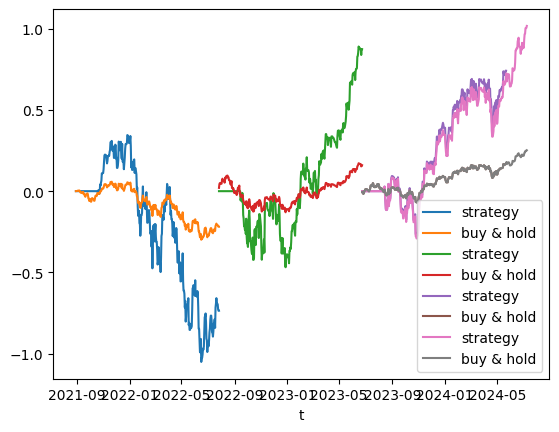

In [13]:
model =Ridge(alpha = 500, fit_intercept = False, solver = 'saga')
data = read_data('NQ')
out = walk_forward_optimization(data, model)

In [14]:
out

,train_start,train_end,test_start,test_end,sharpe_ratio,annual_return,volatility,correction_factor
0,2018-01-01 18:00:00,2022-07-27 07:25:00,2021-08-30 16:15:00,2022-07-27 07:25:00,-0.826374,-0.808686,0.978596,1.000000
1,2018-11-29 01:15:00,2023-06-23 01:55:00,2022-07-27 07:30:00,2023-06-23 01:55:00,1.149908,0.960774,0.835522,1.000000
2,2019-10-30 13:45:00,2024-05-21 11:30:00,2023-06-23 02:00:00,2024-05-21 11:30:00,1.346686,0.809834,0.601353,1.000000
3,2019-10-30 13:45:00,2023-06-23 01:55:00,2023-06-23 02:00:00,2024-07-08 11:30:00,1.629211,0.971452,0.596271,1.142857
Average,NaT,NaT,NaT,NaT,0.852594,0.500175,0.747534,NaN


# Попробуем другие модели и сравним результаты

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.94s/it]

Sharpe ratio = 1.89
Annual Return = 0.06
Annual Std = 0.03
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:14<00:36, 36.48s/it]

Sharpe ratio = 2.06
Annual Return = 0.05
Annual Std = 0.02
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:42<00:00, 34.09s/it]

Sharpe ratio = 2.21
Annual Return = 0.02
Annual Std = 0.01
[  100   166   278   464   774  1291  2154  3593  5994 10000]


[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 2.52
Annual Return = 0.03
Annual Std = 0.01


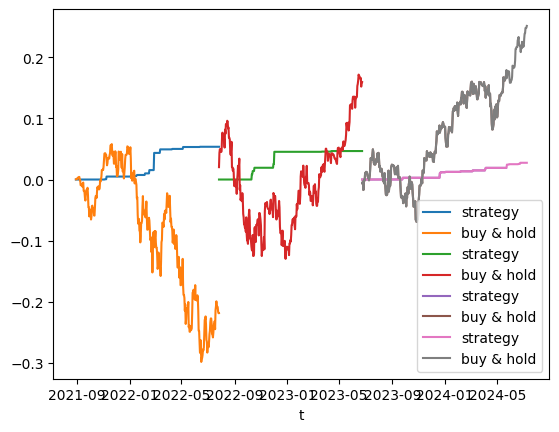

In [16]:
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
data = read_data('NQ')
out = walk_forward_optimization(data, model)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 33%|████████████████████████████                                                        | 1/3 [00:23<00:47, 23.68s/it]

Sharpe ratio = 0.92
Annual Return = 0.91
Annual Std = 0.98
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:48<00:24, 24.37s/it]

Sharpe ratio = -0.93
Annual Return = -0.79
Annual Std = 0.85
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


C:\Users\lena_\AppData\Local\Temp\ipykernel_836\2130854178.py:52: RuntimeWarning: divide by zero encountered in divide
  features['position'] = predictions / train_std
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:13<00:00, 24.48s/it]


Sharpe ratio = nan
Annual Return = 0.00
Annual Std = 0.00
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = -1.59
Annual Return = -0.95
Annual Std = 0.60


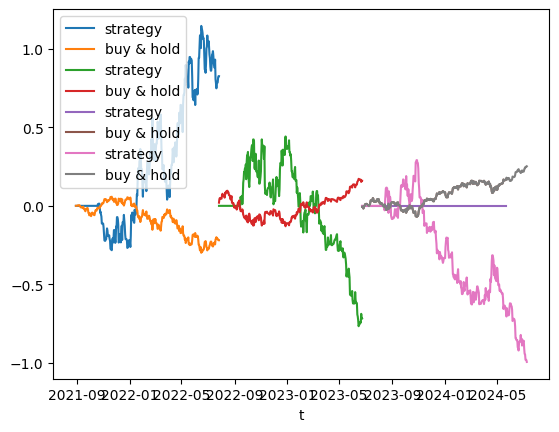

In [20]:
model = ElasticNet(alpha=100, l1_ratio=0.5)
data = read_data('NQ')
out = walk_forward_optimization(data, model)

In [21]:
out

,train_start,train_end,test_start,test_end,sharpe_ratio,annual_return,volatility,correction_factor
0,2018-01-01 18:00:00,2022-07-27 07:25:00,2021-08-30 16:15:00,2022-07-27 07:25:00,0.921410,0.907167,0.984543,1.000000
1,2018-11-29 01:15:00,2023-06-23 01:55:00,2022-07-27 07:30:00,2023-06-23 01:55:00,-0.931919,-0.788625,0.846238,1.000000
2,2019-10-30 13:45:00,2024-05-21 11:30:00,2023-06-23 02:00:00,2024-05-21 11:30:00,NaN,0.000000,0.000000,1.000000
3,2019-10-30 13:45:00,2023-06-23 01:55:00,2023-06-23 02:00:00,2024-07-08 11:30:00,-1.586286,-0.948929,0.598208,1.142857
Average,NaT,NaT,NaT,NaT,NaN,-0.233160,0.606935,NaN


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 33%|███████████████████████████▋                                                       | 1/3 [16:16<32:33, 976.93s/it]

Sharpe ratio = 5.72
Annual Return = 0.59
Annual Std = 0.10
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [31:49<15:50, 950.70s/it]

Sharpe ratio = 4.28
Annual Return = 0.87
Annual Std = 0.20
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [47:04<00:00, 941.63s/it]

Sharpe ratio = 5.89
Annual Return = 0.52
Annual Std = 0.09
[  100   166   278   464   774  1291  2154  3593  5994 10000]


[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 6.00
Annual Return = 0.31
Annual Std = 0.05


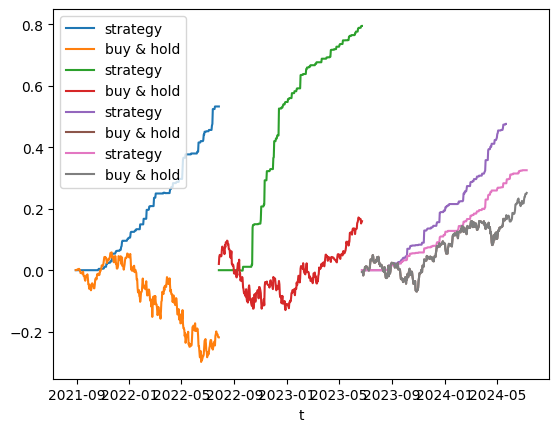

In [22]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5)
data = read_data('NQ')
out = walk_forward_optimization(data, model)

In [24]:
out

,train_start,train_end,test_start,test_end,sharpe_ratio,annual_return,volatility,correction_factor
0,2018-01-01 18:00:00,2022-07-27 07:25:00,2021-08-30 16:15:00,2022-07-27 07:25:00,5.722047,0.586301,0.102463,1.000000
1,2018-11-29 01:15:00,2023-06-23 01:55:00,2022-07-27 07:30:00,2023-06-23 01:55:00,4.277680,0.874793,0.204502,1.000000
2,2019-10-30 13:45:00,2024-05-21 11:30:00,2023-06-23 02:00:00,2024-05-21 11:30:00,5.894295,0.520803,0.088357,1.000000
3,2019-10-30 13:45:00,2023-06-23 01:55:00,2023-06-23 02:00:00,2024-07-08 11:30:00,5.997630,0.311117,0.051873,1.142857
Average,NaT,NaT,NaT,NaT,5.491007,0.564214,0.109733,NaN


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 33%|████████████████████████████                                                        | 1/3 [00:36<01:13, 36.86s/it]

Sharpe ratio = 5.51
Annual Return = 0.31
Annual Std = 0.06
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:11<00:35, 35.43s/it]

Sharpe ratio = 4.50
Annual Return = 0.44
Annual Std = 0.10
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:46<00:00, 35.43s/it]

Sharpe ratio = 5.66
Annual Return = 0.27
Annual Std = 0.05
[  100   166   278   464   774  1291  2154  3593  5994 10000]


[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 5.40
Annual Return = 0.27
Annual Std = 0.05


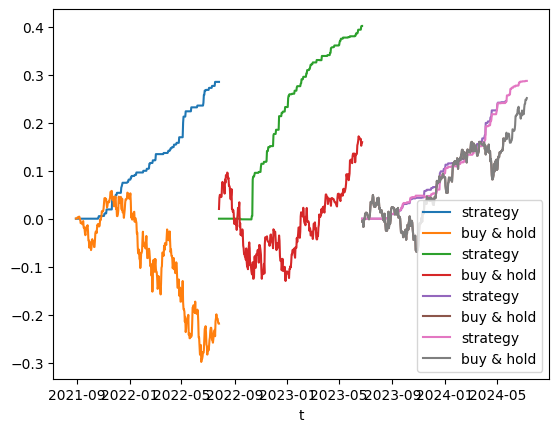

In [30]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(depth=6, iterations=100, learning_rate=0.1, verbose=0)
data = read_data('NQ')
out = walk_forward_optimization(data, model)

In [31]:
out

,train_start,train_end,test_start,test_end,sharpe_ratio,annual_return,volatility,correction_factor
0,2018-01-01 18:00:00,2022-07-27 07:25:00,2021-08-30 16:15:00,2022-07-27 07:25:00,5.509727,0.313783,0.056951,1.000000
1,2018-11-29 01:15:00,2023-06-23 01:55:00,2022-07-27 07:30:00,2023-06-23 01:55:00,4.501413,0.442144,0.098223,1.000000
2,2019-10-30 13:45:00,2024-05-21 11:30:00,2023-06-23 02:00:00,2024-05-21 11:30:00,5.662351,0.268369,0.047395,1.000000
3,2019-10-30 13:45:00,2023-06-23 01:55:00,2023-06-23 02:00:00,2024-07-08 11:30:00,5.395112,0.274680,0.050913,1.142857
Average,NaT,NaT,NaT,NaT,5.271563,0.323017,0.062941,NaN


Выводы:
1. ElasticNet отрабатывает не совсем хорошо, видно что результат сильно зависит от гиперпараметров модели (в частности от alpha). При маленьком alpha будет в среднем прирост годовой, но совсем маленький. Если alpha большое, то визуально видно, что при медвежем тренде будет прирост, а при бычем наоборот. Возможно подбор гиперпараметров улучшил бы метрики, но здесь в этом нет нужды. Волатильность очень большая. Модель скорее всего не подойдет.
2. Случайный лес дал наилучший результат. Средний sharp ratio = 5.49, annual return = 56 %, что очень даже хорошо при условии что волатильность низкая около 0.1. Смотря на графики, можно заметить, что модель хорошо справляется и когда нужно шортить и когда нужно наоборот лонг.
3. Градиентный бустинг catboost дал тоже хороший результат, sharp ratio примерно равный предыдущей модели, но annual return меньше. Здесь для полного утверждения, какая модель лучше, следовало бы провести подбор гиперпараметров для обоих моделей и в конце сравнить модели на лучших гиперпараметрах. В следующей тетрадке я займусь этим.
4. Также стоит отметить, что лучше провести подбор наиболее лучшего параметра pos_limit. От него многое зависит (риски и прибыльность).

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 33%|████████████████████████████                                                        | 1/3 [00:25<00:51, 25.68s/it]

Sharpe ratio = 4.92
Annual Return = 0.68
Annual Std = 0.14
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:50<00:25, 25.30s/it]

Sharpe ratio = 5.08
Annual Return = 1.48
Annual Std = 0.29
[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:19<00:00, 26.52s/it]

Sharpe ratio = 5.22
Annual Return = 1.23
Annual Std = 0.24
[  100   166   278   464   774  1291  2154  3593  5994 10000]


[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 5.13
Annual Return = 1.04
Annual Std = 0.20


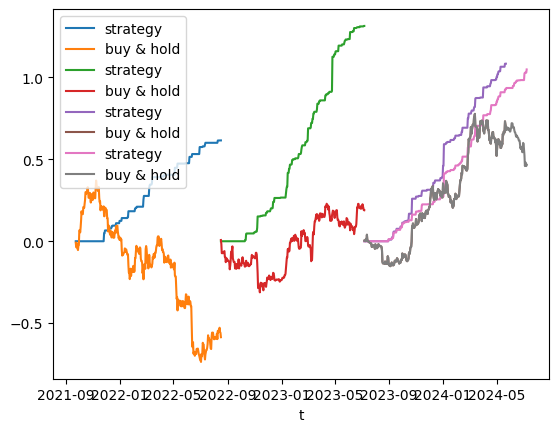

In [33]:
model = CatBoostRegressor(depth=6, iterations=100, learning_rate=0.1, verbose=0)
data = read_data('BTC')
out = walk_forward_optimization(data, model)

In [34]:
out

,train_start,train_end,test_start,test_end,sharpe_ratio,annual_return,volatility,correction_factor
0,2018-01-01 18:00:00,2022-08-17 15:20:00,2021-09-23 18:10:00,2022-08-17 15:20:00,4.924839,0.683610,0.138809,1.000000
1,2019-01-04 11:00:00,2023-07-07 08:00:00,2022-08-17 15:25:00,2023-07-07 08:00:00,5.079902,1.477809,0.290913,1.000000
2,2019-12-19 03:50:00,2024-05-22 18:35:00,2023-07-07 08:05:00,2024-05-22 18:35:00,5.215492,1.233756,0.236556,1.000000
3,2019-12-19 03:50:00,2023-07-07 08:00:00,2023-07-07 08:05:00,2024-07-08 12:35:00,5.129263,1.041350,0.203021,1.142893
Average,NaT,NaT,NaT,NaT,5.088819,1.106793,0.216831,NaN
